# Lesson 4: Persistence and Streaming

In [44]:
#!pip install aiosqlite==0.20.0

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=2)

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [7]:
from langgraph.checkpoint.sqlite import SqliteSaver # a checkpointer checkpoints the state after, and between every node. There are several.

memory = SqliteSaver.from_conn_string(":memory:") # we'll just use an in-memory database, but you can connect to external ones too - redis / postgres / sqllite etc.

In [6]:
class Agent:
    def __init__(self, model, tools, checkpointer, system=""): # so we include checkpointer ehre
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)  # and when we compile we pass it in, and that way it just automatically saves the state
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [8]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [33]:
messages = [HumanMessage(content="What is the weather in glasgow?")]

In [34]:
# a thread config is used to keep track of threads inside the persistant checkpointer - it allows multiple convos at same time 
# you'll need this if you have production apps ( multiple users)
# it's a dictionary with a configurable key - there is a thread_id that is any string - we set it to 1 here


thread = {"configurable": {"thread_id": "1"}} 

In [35]:
# we are using stream instead of invoke - we're basically calling the graph now
# we pass in messages as before - but we pass in the thread config as a second param
# we will start getting  a sream of  events
# events represent updatse to that state over time

for event in abot.graph.stream({"messages": messages}, thread):
    # in our state, we only have one key "messages" so we'll just print it out 
    for v in event.values():       
        print("<event>\n", v['messages'], "\n</event>")

<event>
 [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1s6SmXUDBLGzLMI8ZaNiSr0T', 'function': {'arguments': '{"query":"current weather in Southwark, Glasgow"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 3771, 'total_tokens': 3796}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_f4e629d0a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d2af585e-990f-4fa8-8468-ab2b7f8c7b7c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Southwark, Glasgow'}, 'id': 'call_1s6SmXUDBLGzLMI8ZaNiSr0T'}])] 
</event>
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Southwark, Glasgow'}, 'id': 'call_1s6SmXUDBLGzLMI8ZaNiSr0T'}
Back to the model!
<event>
 [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Glasgow\', \'region\': \'Glasgow City\'

In [36]:
messages = [HumanMessage(content="What about in la?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Npl8pwDaWLRxQFMt0eU1O1yX', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 4648, 'total_tokens': 4670}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_319be4768e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-768904f6-a250-4870-b579-642e5ad4200e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_Npl8pwDaWLRxQFMt0eU1O1yX'}])]}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_Npl8pwDaWLRxQFMt0eU1O1yX'}
Back to the model!
{'messages': [ToolMessage(content="[{'url': 'https://www.accuweather.com/en/us/los-angeles/90012/current-weather/347625', 'content': 'Get the latest weather information for Los Angel

In [37]:
messages = [HumanMessage(content="Which of the places so far is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='Based on the current weather information:\n\n1. **San Francisco, CA:** 13.3°C (55.9°F)\n2. **Southwark, SE1, London:** 13.3°C (55.9°F)\n3. **Southwark, Glasgow:** 15.3°C (59.5°F)\n4. **Los Angeles, CA:** [Please refer to the AccuWeather link for the latest temperature data](https://www.accuweather.com/en/us/los-angeles/90012/current-weather/347625).\n\nFrom the available data, **Southwark, Glasgow** is currently the warmest with a temperature of 15.3°C (59.5°F). For the most accurate comparison that includes Los Angeles, please check the current temperature on the provided AccuWeather link.', response_metadata={'token_usage': {'completion_tokens': 170, 'prompt_tokens': 4911, 'total_tokens': 5081}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_9cb5d38cf7', 'finish_reason': 'stop', 'logprobs': None}, id='run-5f24a72d-ce45-43d5-9d6a-9fe3ac5922d0-0')]}


In [38]:
# notice here by saying thread_id = 2 we create a new thread / state and thus there's no persistant data.

messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='Could you please provide more context or specify the two items or locations you are comparing in terms of warmth? This will help me provide a more accurate answer.', response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 149, 'total_tokens': 181}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_319be4768e', 'finish_reason': 'stop', 'logprobs': None}, id='run-ae768f79-71c2-46c8-81e2-266032e2059e-0')]}


## Streaming tokens

In [45]:
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver

memory = AsyncSqliteSaver.from_conn_string(":memory:")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [ ]:
messages = [HumanMessage(content="What is the weather in SF?")]
thread = {"configurable": {"thread_id": "4"}}

# astream events is the asynchronous event generator (compare to abot.graph.stream)
# it comes on all langchain and langgraph objects
# we need to use an async checkpointer - and that's what AsyncSqlliteSaver is (it's similar to before but we swap out synchronous one for async one)
# this lets us use async events on the graph

async for event in abot.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    # we want to look for events that correspond to new tokens 
    # these kind of events are called on_chat_model_stream events 
    if kind == "on_chat_model_stream": 
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")

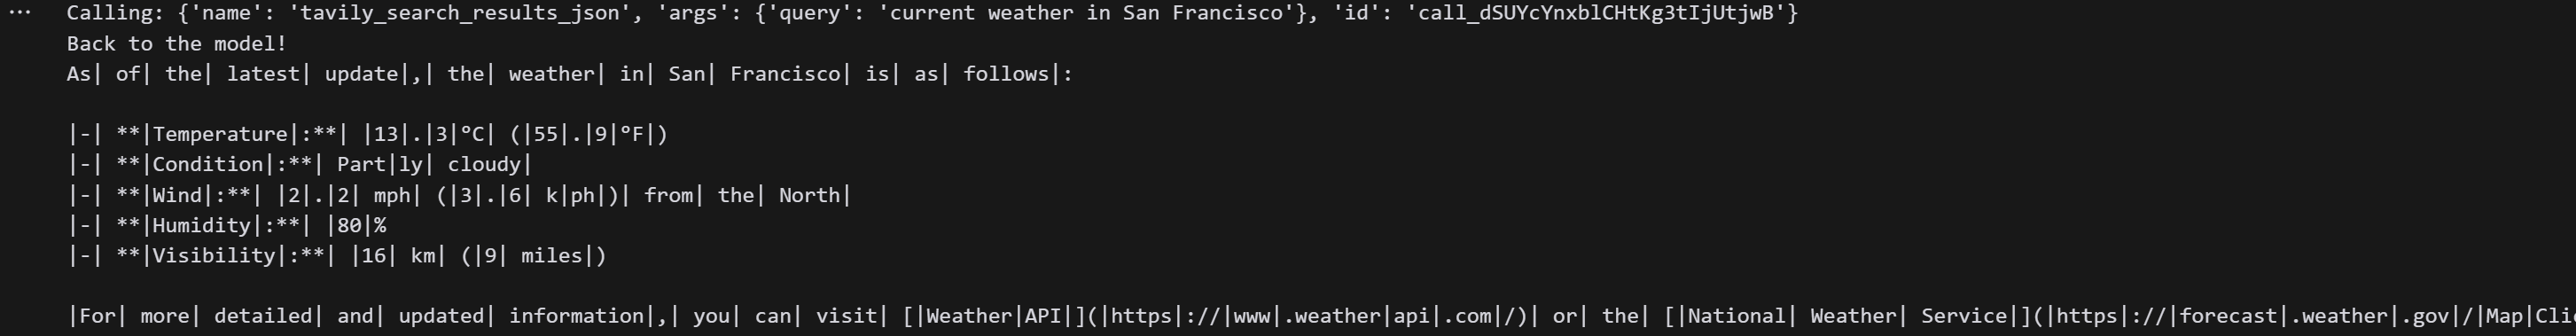

Look at the above output

When it calls the tavily agent, there are no streaming tokens returned - it's fully just a data object that arrives in a wunner

Wheras the chat model DOES do tokens - thus we can stream them